# 3. Análise Exploratória e Consultas SQL

## 3.1 Objetivo
Compreender os dados através de análises estatísticas e consultas SQL que respondam às pergun-
tas de pesquisa, garantindo que os dados estejam em formato adequado para análise.

In [317]:
import os
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import os, json, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

CSV_PATH = "/DADOS_LIMPOS_ENEM.csv"
OUT_DIR = "/results_step3"
PARQUET_PATH = "/DADOS_TIDY_ENEM.parquet"
SQLITE_PATH = os.path.join(OUT_DIR, "enem.db")
ZIP_PATH = "/results_step3.zip"

os.makedirs(OUT_DIR, exist_ok=True)

## 3.2 Preparação dos Dados em Formato Tidy
### 3.2.1 Organização dos Dados
Transformar o dataset limpo para formato tidy data seguindo os princípios fundamentais: cada
variável forma uma coluna, cada observação forma uma linha e cada tipo de unidade observacio-
nal forma uma tabela.
### 3.2.2 Reestruturação Necessária
• Transformações estruturais: Converter dados wide em long format quando necessário

• Normalização: Separar variáveis compostas em colunas distintas

• Padronização de tipos: Garantir tipos de dados apropriados

• Exportar dados preparados em formato Parquet

In [318]:
df = pd.read_csv(CSV_PATH, sep=';', encoding='latin1', low_memory=False)

print("Dimensões:", df.shape)
display(df.head(8))

Dimensões: (104687, 16)


,NU_ANO,SG_UF_ESCOLA,TP_DEPENDENCIA_ADM_ESCOLA,TP_LOCALIZACAO_ESCOLA,PORTE_ESCOLA,NU_MEDIA_CN,NU_MEDIA_CH,NU_MEDIA_LP,NU_MEDIA_MT,NU_MEDIA_RED,NU_MATRICULAS,NU_PARTICIPANTES,NU_TAXA_PARTICIPACAO,NU_TAXA_APROVACAO,NU_TAXA_REPROVACAO,NU_TAXA_ABANDONO
0,2014,RO,4,1,Maior que 90 alunos,604.88,647.29,592.34,629.14,718.53,145,136,93.79,95.4,4.6,0.0
1,2015,RO,4,1,Maior que 90 alunos,591.64,652.34,604.53,627.66,732.00,137,130,94.89,96.1,3.9,0.0
2,2009,RO,4,1,Maior que 90 alunos,622.92,624.16,598.73,592.42,707.29,220,144,65.50,95.5,4.5,0.0
3,2011,RO,4,1,Maior que 90 alunos,589.18,587.03,617.56,683.44,649.24,200,158,79.00,92.4,7.3,0.3
4,2012,RO,4,1,Maior que 90 alunos,587.74,624.71,576.79,660.32,653.02,272,252,92.65,95.0,4.9,0.1
5,2013,RO,4,1,Maior que 90 alunos,596.94,628.01,583.20,660.30,668.76,193,185,95.85,94.6,5.4,0.0
6,2010,RO,4,1,Maior que 90 alunos,596.21,652.30,603.57,646.95,694.28,168,166,98.80,96.6,3.2,0.2
7,2013,RO,4,1,De 1 a 30 alunos,484.09,529.63,508.30,493.00,530.48,30,21,70.00,90.6,8.2,1.2


In [338]:

df.columns = (
    df.columns
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
)


rename_map = {c: c.replace('nu_media_', 'nota_') for c in df.columns if c.startswith('nu_media_')}
df.rename(columns=rename_map, inplace=True)

print("Colunas após normalização e renomeação:")
print(df.columns.tolist())

nota_cols = [c for c in df.columns if c.startswith('nota_')]
print("\nColunas de nota detectadas:", nota_cols)

num_cols = ['idade', 'nu_ano'] + nota_cols
for c in num_cols:
    if c in df.columns:
        df[c] = (
            df[c]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .replace(['nan', 'None', ''], np.nan)
        )
        df[c] = pd.to_numeric(df[c], errors='coerce')


cat_cols = [
    'sexo',
    'sg_uf_escola',
    'tp_dependencia_adm_escola',
    'tp_localizacao_escola',
    'porte_escola',
    'escola_publica',
    'presente_redacao',
    'presente_mt'
]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

df.to_parquet(PARQUET_PATH, index=False)
print("\nParquet salvo em:", PARQUET_PATH)

display(df.head(6))



Colunas após normalização e renomeação:
['nu_ano', 'sg_uf_escola', 'tp_dependencia_adm_escola', 'tp_localizacao_escola', 'porte_escola', 'nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red', 'nu_matriculas', 'nu_participantes', 'nu_taxa_participacao', 'nu_taxa_aprovacao', 'nu_taxa_reprovacao', 'nu_taxa_abandono', 'media_total']

Colunas de nota detectadas: ['nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red']

Parquet salvo em: /DADOS_TIDY_ENEM.parquet


,nu_ano,sg_uf_escola,tp_dependencia_adm_escola,tp_localizacao_escola,porte_escola,nota_cn,nota_ch,nota_lp,nota_mt,nota_red,nu_matriculas,nu_participantes,nu_taxa_participacao,nu_taxa_aprovacao,nu_taxa_reprovacao,nu_taxa_abandono,media_total
0,2014,RO,4,1,Maior que 90 alunos,604.88,647.29,592.34,629.14,718.53,145,136,93.79,95.4,4.6,0.0,638.436
1,2015,RO,4,1,Maior que 90 alunos,591.64,652.34,604.53,627.66,732.00,137,130,94.89,96.1,3.9,0.0,641.634
2,2009,RO,4,1,Maior que 90 alunos,622.92,624.16,598.73,592.42,707.29,220,144,65.50,95.5,4.5,0.0,629.104
3,2011,RO,4,1,Maior que 90 alunos,589.18,587.03,617.56,683.44,649.24,200,158,79.00,92.4,7.3,0.3,625.290
4,2012,RO,4,1,Maior que 90 alunos,587.74,624.71,576.79,660.32,653.02,272,252,92.65,95.0,4.9,0.1,620.516
5,2013,RO,4,1,Maior que 90 alunos,596.94,628.01,583.20,660.30,668.76,193,185,95.85,94.6,5.4,0.0,627.442


## 3.3 Consultas SQL Analíticas (5+ obrigatórias)
Desenvolver consultas que revelem insights interessantes a partir dos dados em formato tidy, explorando:

• Agregações complexas: Análises por grupos e períodos (ou equivalentes)

• Análises temporais: Funções de janela para tendências e rankings

• Consultas hierárquicas: CTEs para análises em múltiplos níveis

Exemplos de tipos de consultas:
1. Tendências temporais e sazonalidade
2. Comparações entre grupos e categorias
3. Análises de concentração e distribuição
4. Detecção de padrões e anomalias
5. Correlações e dependências entre variávei

In [339]:
import sqlite3
import duckdb
# Carregar o parquet tidy
df_tidy = pd.read_parquet(PARQUET_PATH)

# Registrar no DuckDB
duckdb.register('enem', df_tidy)

SQLITE_PATH = "enem.db"

if os.path.exists(SQLITE_PATH):
    os.remove(SQLITE_PATH)
conn = sqlite3.connect(SQLITE_PATH)
df.to_sql('enem', conn, if_exists='replace', index=False)

print("Tabela 'enem' criada com sucesso no SQLite:", SQLITE_PATH)

Tabela 'enem' criada com sucesso no SQLite: enem.db


### 1. Média de notas por estado (agregação complexa)


In [340]:
q1 = """
SELECT
    sg_uf_escola AS estado,
    ROUND(AVG(nota_cn), 2) AS media_cn,
    ROUND(AVG(nota_ch), 2) AS media_ch,
    ROUND(AVG(nota_lp), 2) AS media_lp,
    ROUND(AVG(nota_mt), 2) AS media_mt,
    ROUND(AVG(nota_red), 2) AS media_redacao,
    ROUND((AVG(nota_cn) + AVG(nota_ch) + AVG(nota_lp) + AVG(nota_mt) + AVG(nota_red)) / 5, 2) AS media_geral
FROM enem
GROUP BY estado
ORDER BY media_geral DESC;
"""
print("📊 Média de notas por estado (sem nota_total)")
display(duckdb.query(q1).to_df())


📊 Média de notas por estado (sem nota_total)


,estado,media_cn,media_ch,media_lp,media_mt,media_redacao,media_geral
0,DF,510.30,558.95,538.04,534.92,578.56,544.15
1,RJ,507.20,553.93,530.90,535.57,587.94,543.11
2,SP,507.21,546.77,530.91,539.66,579.55,540.82
3,MG,503.55,541.02,518.44,533.02,565.89,532.38
4,RS,494.61,534.72,516.87,521.51,560.10,525.56
5,SC,498.66,536.71,509.65,519.08,555.58,523.94
6,PR,493.35,529.85,508.31,514.33,545.73,518.32
7,BA,482.29,526.29,498.75,494.66,567.62,513.92
8,GO,486.62,526.63,503.23,499.63,539.73,511.17
9,PE,476.85,519.85,499.37,494.89,545.95,507.38


### 2. Tendência temporal (análise temporal)


In [341]:
q2 = """
SELECT
    nu_ano AS ano,
    ROUND(AVG(nota_cn), 2) AS media_cn,
    ROUND(AVG(nota_ch), 2) AS media_ch,
    ROUND(AVG(nota_lp), 2) AS media_lp,
    ROUND(AVG(nota_mt), 2) AS media_mt,
    ROUND(AVG(nota_red), 2) AS media_redacao
FROM enem
GROUP BY ano
ORDER BY ano;
"""
print("Tendência temporal das notas por área")
display(duckdb.query(q2).to_df())


Tendência temporal das notas por área


,ano,media_cn,media_ch,media_lp,media_mt,media_redacao
0,2009,496.60,496.66,495.14,495.71,579.91
1,2010,481.82,534.53,505.92,504.59,591.03
2,2011,489.48,494.46,537.22,555.24,559.45
3,2012,491.43,536.72,505.01,540.99,533.04
4,2013,488.30,529.77,502.03,535.44,537.90
5,2014,498.74,555.98,520.02,495.66,515.40
6,2015,490.87,566.76,515.31,492.57,563.77


### 3. Comparação entre grupos (público x privado)

In [342]:
q3 = """
SELECT
  CASE tp_dependencia_adm_escola
       WHEN 1 THEN 'Federal'
       WHEN 2 THEN 'Estadual'
       WHEN 3 THEN 'Municipal'
       WHEN 4 THEN 'Privada'
       ELSE 'Outro'
  END AS tipo_escola,
  ROUND(AVG(nota_cn),2) AS media_cn,
  ROUND(AVG(nota_ch),2) AS media_ch,
  ROUND(AVG(nota_lp),2) AS media_lp,
  ROUND(AVG(nota_mt),2) AS media_mt,
  ROUND(AVG(nota_red),2) AS media_red,
  COUNT(*) AS qtd
FROM enem
GROUP BY tipo_escola
ORDER BY media_cn DESC;
"""
print("Comparação: escolas públicas vs privadas")
display(duckdb.query(q3).to_df())

Comparação: escolas públicas vs privadas


,tipo_escola,media_cn,media_ch,media_lp,media_mt,media_red,qtd
0,Federal,543.14,588.18,555.00,586.35,620.24,1634
1,Privada,537.12,577.19,552.48,576.55,613.81,38567
2,Municipal,480.13,518.66,503.28,500.94,555.90,975
3,Estadual,461.68,502.90,483.08,472.67,520.87,63511


### 4. Ranking de estados por média (funções de janela)

In [343]:
q4 = """
WITH medias_estado AS (
  SELECT sg_uf_escola AS estado,
         ROUND(AVG(nota_cn + nota_ch + nota_lp + nota_mt + nota_red)/5,2) AS media_estado
  FROM enem
  GROUP BY estado
)
SELECT estado,
       media_estado,
       RANK() OVER (ORDER BY media_estado DESC) AS posicao
FROM medias_estado;
"""
print("Ranking de estados por média geral (função de janela)")
display(duckdb.query(q4).to_df())

Ranking de estados por média geral (função de janela)


,estado,media_estado,posicao
0,DF,544.21,1
1,RJ,543.29,2
2,SP,540.90,3
3,MG,532.48,4
4,RS,525.59,5
5,SC,524.04,6
6,PR,518.44,7
7,BA,514.07,8
8,GO,511.26,9
9,PE,507.54,10


### 5. Correlação entre áreas



In [344]:
q5 = """
SELECT
  CORR(nota_mt, nota_cn) AS "Matemática x Ciências",
  CORR(nota_lp, nota_ch) AS "Linguagens x Humanas",
  CORR(nota_red, nota_lp) AS "Redação x Linguagens"
FROM enem;
"""
print("Correlação entre áreas de conhecimento e redação")
display(duckdb.query(q5).to_df())

Correlação entre áreas de conhecimento e redação


,Matemática x Ciências,Linguagens x Humanas,Redação x Linguagens
0,0.880465,0.846345,0.719746


## 3.4 Análise Exploratória e Teste de Hipóteses
Compreender a estrutura dos dados através de análises estatísticas progressivas e verificação pre-
liminar das hipóteses de pesquisa, incluindo:

• Análise univariada: Distribuições, medidas de tendência central e dispersão, identificação
de padrões e valores atípicos

• Análise bivariada: Correlações entre variáveis, visualizações de relacionamentos, compara-
ções entre grupos

• Análise multivariada (quando relevante): Matriz de correlações, análises de agrupamento,
técnicas de redução dimensional

• Teste de hipóteses: Formulação e verificação preliminar das hipóteses através de testes estatísticos apropriados e validação visual

Todas as análises devem ser acompanhadas de visualizações e interpretações que conectem os
achados às perguntas de pesquisa.

In [326]:
df_current_analysis = pd.read_parquet(PARQUET_PATH)


# tradução
tipo_escola = {
    1: 'Federal',
    2: 'Estadual',
    3: 'Municipal',
    4: 'Privada'
}

localizacao = {
    1: 'Urbana',
    2: 'Rural'
}
label_map = {
    'nota_cn': 'Ciências da Natureza',
    'nota_ch': 'Ciências Humanas',
    'nota_lp': 'Linguagens e Códigos',
    'nota_mt': 'Matemática',
    'nota_red': 'Redação'
}

### Análise Univariada

Objetivo: entender a distribuição geral das notas por área.

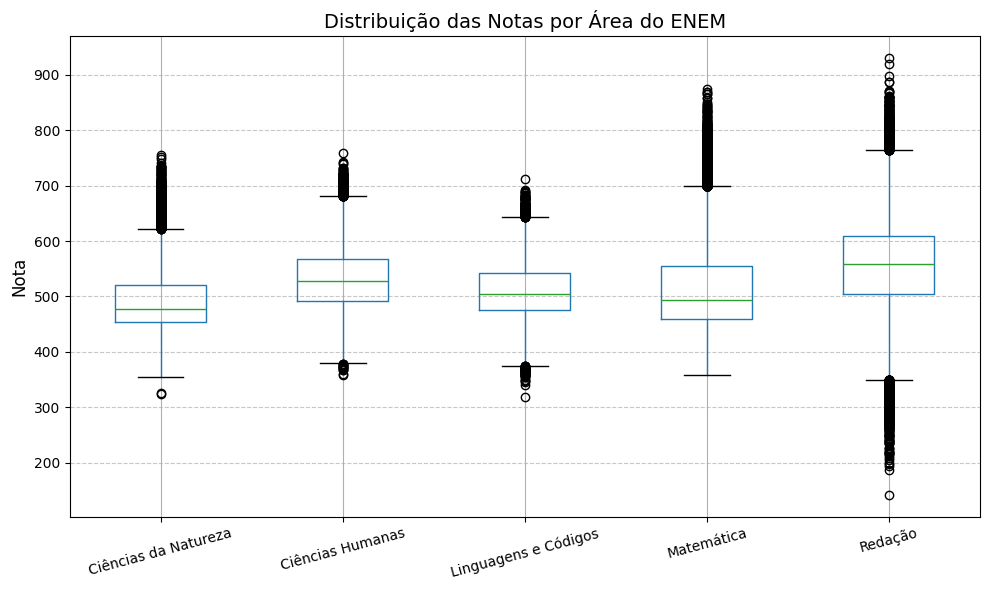


Interpretação:
As distribuições revelam diferenças claras entre as áreas do ENEM.
Em geral, as notas de Linguagens e Redação tendem a ser mais altas e menos dispersas,
enquanto Matemática apresenta maior variabilidade e medianas mais baixas.
Isso sugere diferenças no nível de dificuldade percebido pelos participantes entre as áreas avaliadas.



In [327]:
nota_cols = list(label_map.keys())

plt.figure(figsize=(10,6))
df[nota_cols].boxplot()
plt.title('Distribuição das Notas por Área do ENEM', fontsize=14)
plt.ylabel('Nota', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xticks(range(1, len(nota_cols)+1), [label_map[c] for c in nota_cols], rotation=15)

plt.tight_layout()
plt.show()

print("""
Interpretação:
As distribuições revelam diferenças claras entre as áreas do ENEM.
Em geral, as notas de Linguagens e Redação tendem a ser mais altas e menos dispersas,
enquanto Matemática apresenta maior variabilidade e medianas mais baixas.
Isso sugere diferenças no nível de dificuldade percebido pelos participantes entre as áreas avaliadas.
""")


### Análise Bivariada (P1)

Pergunta: Como o tipo de administração da escola (pública, privada, federal, etc.) e sua localização (urbana/rural) influenciam as médias das provas do ENEM?

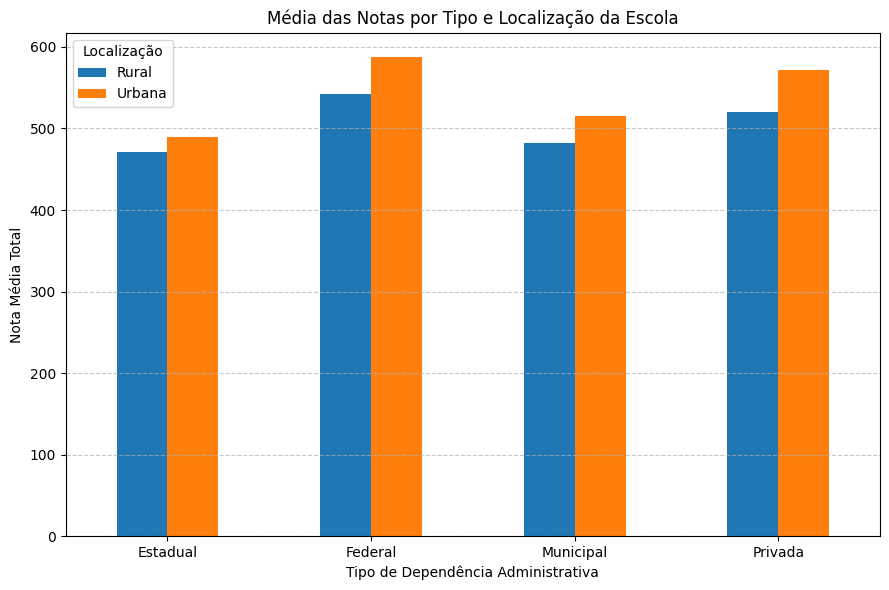


Interpretação:
Escolas privadas e federais apresentam, em média, notas mais altas que as estaduais e municipais.
Além disso, escolas urbanas superam consistentemente as rurais, independentemente do tipo de administração.
Esse padrão reforça desigualdades estruturais entre redes e contextos geográficos de ensino no Brasil.



In [328]:

nota_cols = ['nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red']
df_current_analysis['nota_total'] = df_current_analysis[nota_cols].mean(axis=1)

df_temp = df_current_analysis.copy()
df_temp['tp_dependencia_adm_escola'] = df_temp['tp_dependencia_adm_escola'].map(tipo_escola)
df_temp['tp_localizacao_escola'] = df_temp['tp_localizacao_escola'].map(localizacao)

agrup = (
    df_temp.groupby(['tp_dependencia_adm_escola', 'tp_localizacao_escola'], observed=True)['nota_total']
    .mean()
    .reset_index()
)

pivot = agrup.pivot(index='tp_dependencia_adm_escola',
                    columns='tp_localizacao_escola',
                    values='nota_total')

pivot = pivot.fillna(0)

if pivot.empty:
    print("⚠️  Warning: The pivoted DataFrame is empty, cannot generate plot. Check data for 'tp_dependencia_adm_escola' and 'tp_localizacao_escola' after mapping.")
else:
    pivot.plot(kind='bar', figsize=(9,6))
    plt.title('Média das Notas por Tipo e Localização da Escola')
    plt.xlabel('Tipo de Dependência Administrativa')
    plt.ylabel('Nota Média Total')
    plt.xticks(rotation=0)
    plt.legend(title='Localização')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("""
Interpretação:
Escolas privadas e federais apresentam, em média, notas mais altas que as estaduais e municipais.
Além disso, escolas urbanas superam consistentemente as rurais, independentemente do tipo de administração.
Esse padrão reforça desigualdades estruturais entre redes e contextos geográficos de ensino no Brasil.
""")

### Análise Bivariada (P2)

Pergunta: O porte da escola está associado ao desempenho médio no ENEM?

/tmp/ipython-input-3194056501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['porte_escola', 'tp_dependencia_adm_escola'])['nota_total']


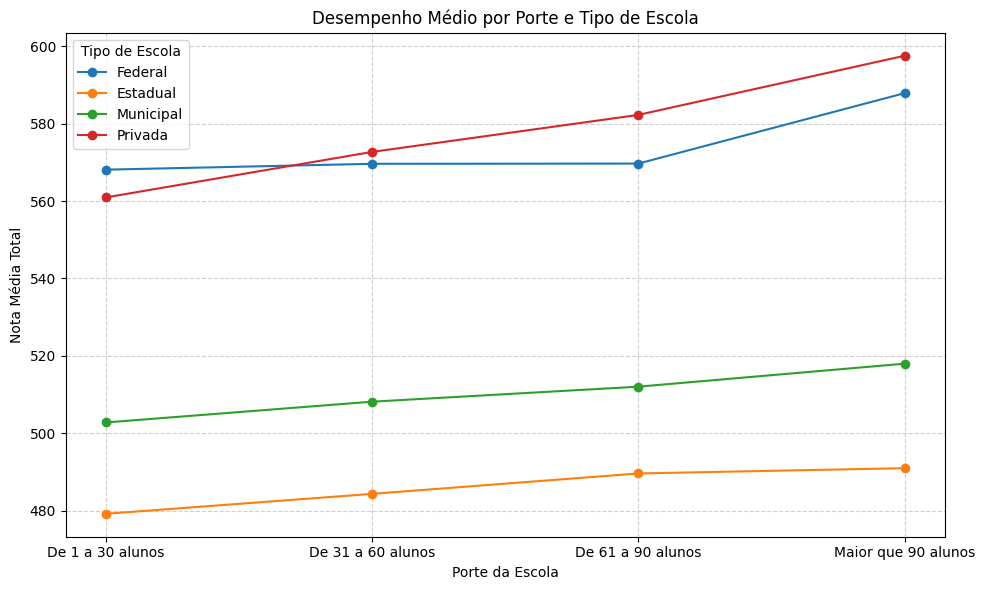


Interpretação (P2):
Há uma tendência de aumento da nota média conforme o porte da escola cresce,
especialmente nas redes Federal e Privada.
Isso sugere que escolas maiores podem dispor de melhor infraestrutura, corpo docente e recursos,
impactando positivamente o desempenho médio dos alunos.



In [329]:
required_cols = ['porte_escola', 'tp_dependencia_adm_escola']
for col in required_cols:
    if col not in df_current_analysis.columns:
        raise KeyError(f"Coluna obrigatória '{col}' não encontrada no dataset.")

area_cols = ['nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red']
existing_area_cols = [c for c in area_cols if c in df_current_analysis.columns]

if 'nota_total' not in df_current_analysis.columns:
    if existing_area_cols:
        df_current_analysis['nota_total'] = df_current_analysis[existing_area_cols].mean(axis=1)
    else:
        raise KeyError("Não encontrou colunas de área para compor 'nota_total'.")

porte_perf = (
    df_current_analysis
    .dropna(subset=['porte_escola', 'tp_dependencia_adm_escola'])
    .groupby(['porte_escola', 'tp_dependencia_adm_escola'])['nota_total']
    .mean()
    .reset_index()
)
def try_num(x):
    try:
        return float(x)
    except Exception:
        return x

porte_perf['porte_escola_num'] = porte_perf['porte_escola'].apply(try_num)

pivot = porte_perf.pivot(index='porte_escola_num', columns='tp_dependencia_adm_escola', values='nota_total')

try:
    pivot = pivot.sort_index()
except Exception:
    pass

plt.figure(figsize=(10,6))
plotted = 0

for col in pivot.columns:
    series = pivot[col]
    if series.dropna().empty:
        continue
    label = tipo_escola.get(col, str(col))
    x = [str(int(v)) if isinstance(v, (int,float)) and float(v).is_integer() else str(v) for v in series.index]
    plt.plot(x, series.values, marker='o', label=label)
    plotted += 1

if plotted == 0:
    print("\n⚠️ Nenhuma série foi plotada — verifique se 'porte_escola' e 'tp_dependencia_adm_escola' têm combinações válidas.")
else:
    plt.title('Desempenho Médio por Porte e Tipo de Escola')
    plt.xlabel('Porte da Escola')
    plt.ylabel('Nota Média Total')
    plt.legend(title='Tipo de Escola', loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "desempenho_por_porte_tipo_escola.png"))
    plt.show()

print("""
Interpretação (P2):
Há uma tendência de aumento da nota média conforme o porte da escola cresce,
especialmente nas redes Federal e Privada.
Isso sugere que escolas maiores podem dispor de melhor infraestrutura, corpo docente e recursos,
impactando positivamente o desempenho médio dos alunos.
""")


### Análise Multivariada

Objetivo: entender como as áreas se correlacionam — se um bom desempenho em uma área tende a vir acompanhado de bom desempenho em outras.

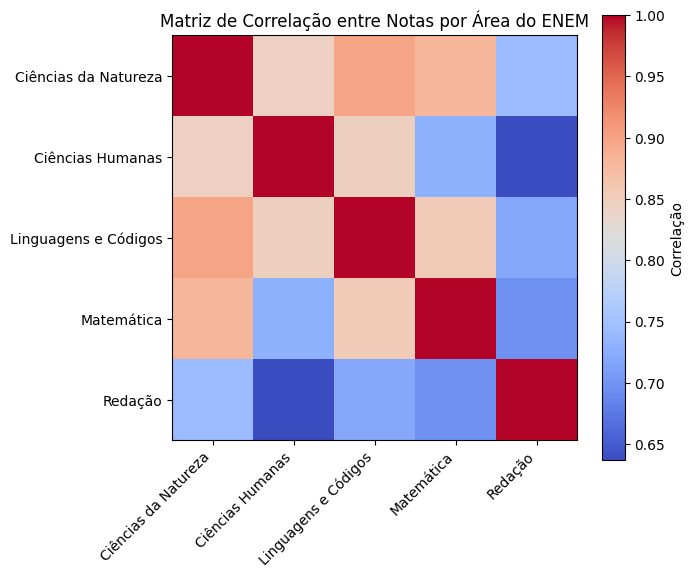


Interpretação:
As correlações são fortes e positivas entre todas as áreas, especialmente entre Linguagens e Redação.
Isso indica que alunos com bom desempenho tendem a se destacar em múltiplas áreas,
possivelmente refletindo habilidades gerais de leitura, interpretação e raciocínio.



In [330]:

nota_cols = list(label_map.keys())

corr = df[nota_cols].corr()

corr.index = [label_map[col] for col in corr.index]
corr.columns = [label_map[col] for col in corr.columns]

plt.figure(figsize=(7,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlação')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Matriz de Correlação entre Notas por Área do ENEM')
plt.tight_layout()
plt.show()

print("""
Interpretação:
As correlações são fortes e positivas entre todas as áreas, especialmente entre Linguagens e Redação.
Isso indica que alunos com bom desempenho tendem a se destacar em múltiplas áreas,
possivelmente refletindo habilidades gerais de leitura, interpretação e raciocínio.
""")


## Testes de Hipóteses

In [350]:
df= pd.read_parquet(PARQUET_PATH)

notas_cols = ['nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red']
df[notas_cols] = df[notas_cols].apply(pd.to_numeric, errors='coerce')

df['media_total'] = df[notas_cols].mean(axis=1)

df_clean = df.dropna(subset=['media_total'])


### H1 — Tipo de Administração e Desempenho

H₀: As médias das escolas privadas/federais são iguais às estaduais/municipais.

H₁: As médias das escolas privadas/federais são maiores que as estaduais/municipais.

Tamanho Privada/Federal: 40201
Tamanho Estadual/Municipal: 64486

Estatística t: 315.6271750121312
p-value: 0.0
Rejeita H₀ — Diferença significativa entre escolas privadas/federais e públicas.


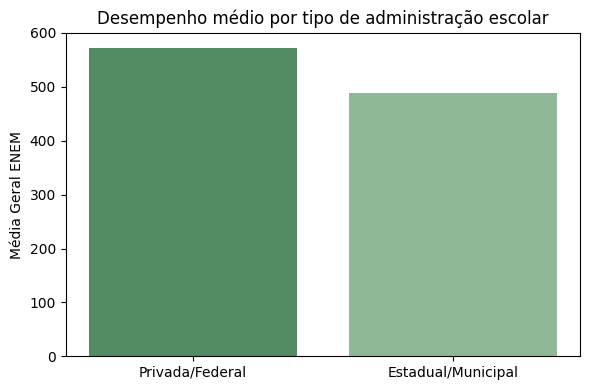

In [366]:
notas_cols = ['nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red']
df[notas_cols] = df[notas_cols].apply(pd.to_numeric, errors='coerce')
df['media_total'] = df[notas_cols].mean(axis=1)
df_clean = df.dropna(subset=['media_total'])


priv_fed = df_clean[df_clean['tp_dependencia_adm_escola'].isin([1, 4])]

pub_est_mun = df_clean[df_clean['tp_dependencia_adm_escola'].isin([2, 3])]

print("Tamanho Privada/Federal:", len(priv_fed))
print("Tamanho Estadual/Municipal:", len(pub_est_mun))

t_stat, p_val = stats.ttest_ind(
    priv_fed['media_total'],
    pub_est_mun['media_total'],
    equal_var=False,
    nan_policy='omit'
)

print("\nEstatística t:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Rejeita H₀ — Diferença significativa entre escolas privadas/federais e públicas.")
else:
    print("Não rejeita H₀ — Diferenças não significativas.")

plt.figure(figsize=(6,4))
plt.bar(['Privada/Federal','Estadual/Municipal'],
        [priv_fed['media_total'].mean(), pub_est_mun['media_total'].mean()],
        color=['#538C63','#8FB996'])
plt.ylabel('Média Geral ENEM')
plt.title('Desempenho médio por tipo de administração escolar')
plt.tight_layout()
plt.show()


In [335]:
print("Total de colunas:", len(df.columns))
print(df.columns.tolist())

Total de colunas: 17
['nu_ano', 'sg_uf_escola', 'tp_dependencia_adm_escola', 'tp_localizacao_escola', 'porte_escola', 'nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red', 'nu_matriculas', 'nu_participantes', 'nu_taxa_participacao', 'nu_taxa_aprovacao', 'nu_taxa_reprovacao', 'nu_taxa_abandono', 'media_total']


In [336]:
print(df.columns.tolist())

['nu_ano', 'sg_uf_escola', 'tp_dependencia_adm_escola', 'tp_localizacao_escola', 'porte_escola', 'nota_cn', 'nota_ch', 'nota_lp', 'nota_mt', 'nota_red', 'nu_matriculas', 'nu_participantes', 'nu_taxa_participacao', 'nu_taxa_aprovacao', 'nu_taxa_reprovacao', 'nu_taxa_abandono', 'media_total']


### H2 — Localização da Escola e Desempenho

H₀: Escolas urbanas e rurais têm desempenho igual.

H₁: Escolas urbanas têm médias maiores que escolas rurais.

Tamanho Urbana: 100864
Tamanho Rural: 3823

Estatística t: 55.34892835962141
p-value: 0.0
Rejeita H₀ — Escolas urbanas têm desempenho superior.


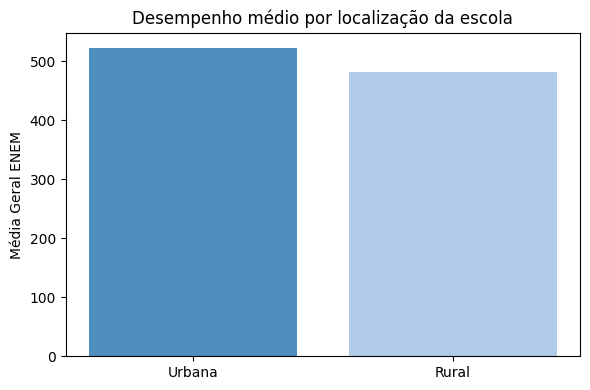

In [359]:
urb = df_clean[df_clean['tp_localizacao_escola'] == 1]
rur = df_clean[df_clean['tp_localizacao_escola'] == 2]

print("Tamanho Urbana:", len(urb))
print("Tamanho Rural:", len(rur))

t_stat2, p_val2 = stats.ttest_ind(
    urb['media_total'],
    rur['media_total'],
    equal_var=False,
    nan_policy='omit'
)

print("\nEstatística t:", t_stat2)
print("p-value:", p_val2)

if p_val2 < 0.05:
    print("Rejeita H₀ — Escolas urbanas têm desempenho superior.")
else:
    print("Não rejeita H₀ — Diferenças não significativas.")

plt.figure(figsize=(6,4))
plt.bar(['Urbana','Rural'],
        [urb['media_total'].mean(), rur['media_total'].mean()],
        color=['#4F8FC0','#B0CBE8'])
plt.ylabel('Média Geral ENEM')
plt.title('Desempenho médio por localização da escola')
plt.tight_layout()
plt.show()


### H3 — Porte da Escola e Desempenho

H₀: Não há correlação entre o porte da escola e as notas médias.

H₁: Há correlação positiva entre o porte da escola e as notas médias.

Correlação Spearman: -0.25723365535540393
p-value: 0.0
Não rejeita H₀ — não há correlação significativa.


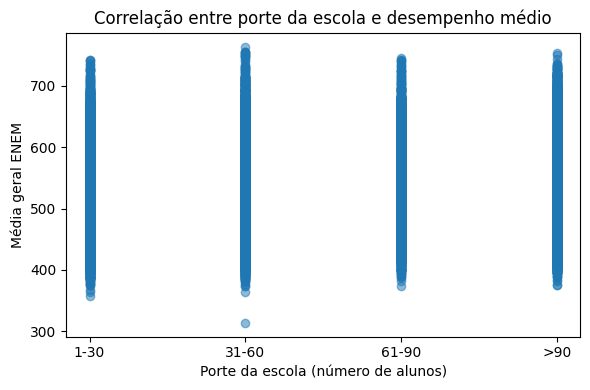

In [367]:
porte_map = {
    'De 1 a 30 alunos': 1,
    'De 31 a 60 alunos': 2,
    'De 61 a 90 alunos': 3,
    'Maior que 90 alunos': 4
}

df['porte_num'] = df['porte_escola'].map(porte_map)
df['media_geral'] = df[['nota_cn','nota_ch','nota_lp','nota_mt','nota_red']].mean(axis=1)
df_valid = df.dropna(subset=['porte_num', 'media_geral'])

corr, p_corr = stats.spearmanr(df_valid['porte_num'], df_valid['media_geral'])
print("Correlação Spearman:", corr)
print("p-value:", p_corr)

if p_corr < 0.05 and corr > 0:
    print("Rejeita H₀ — há correlação positiva significativa (escolas maiores → notas mais altas).")
else:
    print("Não rejeita H₀ — não há correlação significativa.")

plt.figure(figsize=(6,4))
plt.scatter(df_valid['porte_num'], df_valid['media_geral'], alpha=0.5)
plt.xticks([1,2,3,4], ['1-30', '31-60', '61-90', '>90'])
plt.xlabel('Porte da escola (número de alunos)')
plt.ylabel('Média geral ENEM')
plt.title('Correlação entre porte da escola e desempenho médio')
plt.tight_layout()
plt.show()


In [368]:
print(df['porte_escola'].unique())
print(df['porte_escola'].value_counts())


['Maior que 90 alunos', 'De 1 a 30 alunos', 'De 61 a 90 alunos', 'De 31 a 60 alunos']
Categories (4, object): ['De 1 a 30 alunos', 'De 31 a 60 alunos', 'De 61 a 90 alunos',
                         'Maior que 90 alunos']
porte_escola
Maior que 90 alunos    38257
De 31 a 60 alunos      25826
De 1 a 30 alunos       24176
De 61 a 90 alunos      16428
Name: count, dtype: int64
